In [37]:
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import copy

In [38]:
import numpy as np
import cv2
import time
import json

def get_grid_cell_by_location(grid_dict,x,y):
    # This function returns a particular node given its x and y coordinates.

    grid_cell = None
    for loc in grid_dict["node_list"]:
        if loc["x"] == x and loc["y"] == y:
            grid_cell = loc
    return grid_cell

def create_grid_dict_from_array(grid_array):
    # This function converts the numpy array to a dict with information on
    # the number of columns, the number of rows, the start location, and the
    # goal and obstacle status of each cell, as well as possible actions in each cell.

    grid_dict = {}
    grid_dict["num_rows"] = len(grid_array[:,0])
    grid_dict["num_cols"] = len(grid_array[0,:])
    for i in range(len(grid_array[0,:])):
        for j in range(len(grid_array[:,0])):
            if grid_array[i,j] == 5:
                start_x = j
                start_y = i
    grid_dict["start_location"] = {
        "x": start_x,
        "y": start_y
    }
    grid_dict["node_list"] = []
    for i in range(len(grid_array[0,:])):
        for j in range(len(grid_array[:,0])):
            cost = 1
            if np.isnan(grid_array[i,j]):
                wall = True
                cost = np.nan
            else:
                wall = False
            if grid_array[i,j] == 1:
                goal = True
                cost = 0
            else:
                goal = False
            node = {
                "x": j,
                "y": i,
                "cost": cost,
                "goal": goal,
                "wall": wall
            }
            grid_dict["node_list"].append(node)

    for node in grid_dict["node_list"]:
        if node["wall"] == True:
            possible_actions = []
            node["possible_actions"] = possible_actions
            continue
        possible_actions = ["left","right","up","down"]
        x_location = node["x"]
        y_location = node["y"]
        if x_location-1 < 0:
            possible_actions.remove("left")
        else:
            if np.isnan(grid_array[y_location,x_location-1]):
                possible_actions.remove("left")
        if x_location+1 >= len(grid_array[0,:]):
            possible_actions.remove("right")
        else:
            if np.isnan(grid_array[y_location,x_location+1]):
                possible_actions.remove("right")
        if y_location-1 < 0:
            possible_actions.remove("up")
        else:
            if np.isnan(grid_array[y_location-1,x_location]):
                possible_actions.remove("up")
        if y_location+1 >= len(grid_array[:,0]):
            possible_actions.remove("down")
        else:
            if np.isnan(grid_array[y_location+1,x_location]):
                possible_actions.remove("down")
        node["possible_actions"] = possible_actions
        
    out_file = open("grid.json", "w")

    json.dump(grid_dict, out_file, indent = 4)

    out_file.close()
    return grid_dict

def plot_grid(grid_dict,grid):
    # This function plots the grid.

    cell_height = 300
    cell_width = 300
    top_left = (int(cell_height * 0.01), int(cell_width * 0.01))
    bot_right = (int(cell_height * 0.99), int(cell_width * 0.99))
    new_pos = (int(0.5 * cell_width), int(0.5 * cell_height))

    row_concatenation = None
    for row_ind in range(grid_dict["num_rows"]):
        column_concatenation = None

        for col_ind in range(grid_dict["num_cols"]):

            blank_image = np.ones((cell_height, cell_width, 3), np.uint8)
            colored_field = False
            # walls or special states or none
            if np.isnan(grid[row_ind,col_ind]):
                blank_image = blank_image * 128
                blank_image.astype(np.uint8)
            else:
                # white state by default
                blank_image = blank_image * 255
                blank_image = blank_image.astype(np.uint8)

            if grid[row_ind,col_ind] == 5:
                # start percept has border with special color
                txt_size = 2
                txt_color = (170, 255, 255)
                cv2.putText(blank_image, "start", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
                cv2.rectangle(blank_image, top_left, bot_right, (170, 255, 255), int(cell_width * 0.06))
            elif grid[row_ind,col_ind] == 1:
                cost = 1

                if cost > 0:
                    rew_color = (86, 255, 170)
                else:
                    rew_color = (86, 86, 255)

                cv2.rectangle(blank_image, top_left, bot_right, rew_color, int(cell_width * 0.06))

                blank_image = blank_image.astype(np.uint8)

                if colored_field is True:
                    txt_color = (255, 255, 255)
                else:
                    txt_color = rew_color

                if abs(cost) > 9:
                    txt_size = 1
                else:
                    txt_size = 2

                cv2.putText(blank_image, "goal", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
            else:
                cv2.rectangle(blank_image, top_left, bot_right, (0, 0, 0), int(cell_width * 0.03))
            blank_image = blank_image.astype(np.uint8)

            if column_concatenation is None:
                column_concatenation = blank_image
            else:
                column_concatenation = np.concatenate((column_concatenation, blank_image), axis=1)

        if row_concatenation is None:
            row_concatenation = column_concatenation
        else:
            row_concatenation = np.concatenate((row_concatenation, column_concatenation), axis=0)

    cv2.imwrite('grid.png', row_concatenation)

def plot_path(grid_dict,grid,move_sequence):
    # This function plots the grid and the path given in move_sequence. 
    # It also evaluates move_sequence to check for validity.

    curr_location = [grid_dict["start_location"]["x"],grid_dict["start_location"]["y"]]
    i = 0
    path_locations = []
    path_locations.append([curr_location[0],curr_location[1],i])
    for move in move_sequence:
        print(curr_location)
        curr_cell = get_grid_cell_by_location(grid_dict,curr_location[0],curr_location[1])
        print(curr_cell)
        if move not in curr_cell["possible_actions"]:
            print("Illegal move. Path is invalid")
            return
        else:
            if move == "left":
                curr_location = [curr_location[0]-1,curr_location[1]]
            elif move == "right":
                curr_location = [curr_location[0]+1,curr_location[1]]
            elif move == "up":
                curr_location = [curr_location[0],curr_location[1]-1]
            elif move == "down":
                curr_location = [curr_location[0],curr_location[1]+1]
            else:
                print("Move not supported. Path is invalid.")
                return
            i = i+1
            path_locations.append([curr_location[0],curr_location[1],i])
    print(path_locations)
        
    cell_height = 300
    cell_width = 300
    top_left = (int(cell_height * 0.01), int(cell_width * 0.01))
    bot_right = (int(cell_height * 0.99), int(cell_width * 0.99))
    new_pos = (int(0.5 * cell_width), int(0.5 * cell_height))

    row_concatenation = None
    for row_ind in range(grid_dict["num_rows"]):
        column_concatenation = None

        for col_ind in range(grid_dict["num_cols"]):

            blank_image = np.ones((cell_height, cell_width, 3), np.uint8)
            colored_field = False
            # walls or special states or none
            path_ind = None
            on_path = False
            for path_loc in path_locations:
                if path_loc[0] == col_ind and path_loc[1] == row_ind:
                    path_ind = path_loc[2]
                    on_path = True
            if np.isnan(grid[row_ind,col_ind]):
                blank_image = blank_image * 128
                blank_image.astype(np.uint8)
            elif on_path:
                blank_image[:,:,0] = 255
                blank_image[:,:,1] = 0
                blank_image[:,:,2] = 255
                # purple?
            else:
                # white state by default
                blank_image = blank_image * 255
                blank_image = blank_image.astype(np.uint8)


            if grid[row_ind,col_ind] == 5:
                # start percept has border with special color
                txt_size = 2
                txt_color = (170, 255, 255)
                cv2.putText(blank_image, "start", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
                cv2.rectangle(blank_image, top_left, bot_right, (170, 255, 255), int(cell_width * 0.06))

            elif grid[row_ind,col_ind] == 1:
                cost = 1

                if cost > 0:
                    rew_color = (86, 255, 170)
                else:
                    rew_color = (86, 86, 255)

                cv2.rectangle(blank_image, top_left, bot_right, rew_color, int(cell_width * 0.06))

                blank_image = blank_image.astype(np.uint8)

                if colored_field is True:
                    txt_color = (255, 255, 255)
                else:
                    txt_color = rew_color

                if abs(cost) > 9:
                    txt_size = 1
                else:
                    txt_size = 2

                cv2.putText(blank_image, "goal", new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
            elif on_path:
                txt_size = 1
                txt_color = (0,0,0)
                cv2.putText(blank_image, str(path_ind), new_pos,
                            cv2.FONT_HERSHEY_SIMPLEX, txt_size, txt_color, 2, cv2.LINE_AA)
                cv2.rectangle(blank_image, top_left, bot_right, (0, 0, 0), int(cell_width * 0.03))
            else:
                cv2.rectangle(blank_image, top_left, bot_right, (0, 0, 0), int(cell_width * 0.03))
            blank_image = blank_image.astype(np.uint8)

            if column_concatenation is None:
                column_concatenation = blank_image
            else:
                column_concatenation = np.concatenate((column_concatenation, blank_image), axis=1)

        if row_concatenation is None:
            row_concatenation = column_concatenation
        else:
            row_concatenation = np.concatenate((row_concatenation, column_concatenation), axis=0)

    cv2.imwrite('path.png', row_concatenation)


# These are the two pre-defined grids.
grid1 = np.array([[ 1,  1,  1, 0,  1,  1,],
 [ 1,  1,  1,  5,  1,  1,],
 [ 1,  1,  1,  1,  1,  1,],
 [ 1, 0, 0,  1,  1,  1,],
 [ 2, 0,  1, 0,  1,  1,],
 [ 1,  1,  1, 0,  1,  1,]])

grid2 = np.array([[ 1,  1,  1,  2,  1, 0,],
 [ 1,  1,  1,  1,  1,  1,],
 [ 1, 0,  1,  1,  1,  1,],
 [ 1, 0,  1,  1,  1,  1,],
 [ 1, 0, 0,  1, 0,  1,],
 [ 1,  5,  1,  1,  1,  1,]])


# This block creates a 100x100 random grid, with 100 walls
random_grid = np.ones((10,10))
walls = np.random.choice(random_grid.size, 20, replace=False)
goals = np.random.choice(random_grid.size, 1, replace=False)
start = np.random.choice(random_grid.size, 1, replace=False)
random_grid.ravel()[walls] = 0
random_grid.ravel()[goals] = 2
random_grid.ravel()[start] = 5

print(random_grid)
grid = random_grid # or grid 2 or random_grid

grid_dict = create_grid_dict_from_array(grid)

# Comment out the plotting utilities for large grids.
# plot_grid(grid_dict,grid)

start = time.time()
### REPLACE BELOW CODE WITH YOUR ALGORITHMS ###
move_sequence = ["right","down","left","left","left","left","down","down"]
### REPLACE ABOVE CODE WITH YOUR ALGORITHMS ###
end = time.time()
print("Runtime: "+str(end-start))

#plot_path(grid_dict,grid,move_sequence

[[1. 1. 2. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 5. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0.]]
Runtime: 0.0


In [39]:
st_node_1 = []
end_node_1 = []
for i in range(len(grid1)):
    for j in range(len(grid1)):
        if np.isnan(grid1[i][j]):
            grid1[i][j] = 1
        elif grid1[i][j] == 5:
            st_node_1.append((i,j))
            grid1[i][j] =1
        elif grid1[i][j] == 2:
            end_node_1.append((i,j))
            grid1[i][j] =1
            
        
grid1 = [[int(x) for x in row] for row in grid1]

In [40]:
st_node_2 = []
end_node_2 = []
for i in range(len(grid1)):
    for j in range(len(grid2)):
        if np.isnan(grid2[i][j]):
            grid2[i][j] = 1
        elif grid2[i][j] == 5:
            st_node_2.append((i,j))
            grid2[i][j] =1
        elif grid2[i][j] == 2:
            end_node_2.append((i,j))
            grid2[i][j] =1
            
        
grid2 = [[int(x) for x in row] for row in grid2]

In [41]:
st_node = []
end_node = []
for i in range(len(grid)):
    for j in range(len(grid)):
        if np.isnan(grid[i][j]):
            grid[i][j] = 1
        elif grid[i][j] == 5:
            st_node.append((i,j))
            grid[i][j] =1
        elif grid[i][j] == 2:
            end_node.append((i,j))
            grid[i][j] =1
            
        
grid = [[int(x) for x in row] for row in grid]

In [42]:
from collections import deque

# to keep track of the blocks of maze
class Grid_Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# each block will have its own position and cost of steps taken
class Node:
    def __init__(self, pos: Grid_Position, cost):
        self.pos = pos
        self.cost = cost
        
def path_trace_algo(parents, curr_cell):
    global bot_pos,ship
    path = []
    posX,posY = curr_cell.x, curr_cell.y
    while posX != -1 and posY != -1:
        path.append((posX,posY))
        posX,posY = parents[posX][posY]
    return path[::-1]

#BFS algo for the maze
def bfs(Grid, dest: Grid_Position, start: Grid_Position):
    # to get neighbours of current node
    adj_cell_x = [-1, 0, 0, 1]
    adj_cell_y = [0, -1, 1, 0]
    m, n = (len(Grid), len(Grid))
    visited_blocks = [[False for i in range(m)]
                for j in range(n)]
    visited_blocks[start.x][start.y] = True
    queue = deque()
    sol = Node(start, 0)
    queue.append(sol)
    cells = 4
    cost = 0
    shortest_path = []
    poss = []
    parents = [[(-1,-1) for i in range(m)] for i in range(m)]
    while queue:
        
        current_block = queue.popleft()  # Dequeue the front cell
        current_pos = current_block.pos
        if current_pos.x == dest.x and current_pos.y == dest.y:
            # print("Total nodes visited = ", cost)
            a = cost
            path = path_trace_algo(parents,current_pos)
            return current_block.cost, a, path
        
        if current_block not in visited_blocks:
            visited_blocks[current_pos.x][current_pos.y] = True
            cost = cost + 1
            shortest_path.append([current_pos.x,current_pos.y])
        x_pos = current_pos.x
        y_pos = current_pos.y
        poss.append([x_pos, y_pos])

        for i in range(cells):
            if x_pos == len(Grid) - 1 and adj_cell_x[i] == 1:
                x_pos = current_pos.x
                y_pos = current_pos.y + adj_cell_y[i]
            if y_pos == 0 and adj_cell_y[i] == -1:
                x_pos = current_pos.x + adj_cell_x[i]
                y_pos = current_pos.y
            else:
                x_pos = current_pos.x + adj_cell_x[i]
                y_pos = current_pos.y + adj_cell_y[i]
            if x_pos < 6 and y_pos < 6 and x_pos >= 0 and y_pos >= 0:
                if Grid[x_pos][y_pos] == 1:
                    if not visited_blocks[x_pos][y_pos]:
                        next_cell = Node(Grid_Position(x_pos, y_pos),
                                       current_block.cost + 1)
                        visited_blocks[x_pos][y_pos] = True
                        parents[x_pos][y_pos] = (current_pos.x,current_pos.y)
                        queue.append(next_cell)
    return -1

def create_node(x, y, c):
    val = Grid_Position(x, y)
    return Node(val, c + 1)

#dfs algo for maze
def dfs(Grid, dest: Grid_Position, start: Grid_Position):
    adj_cell_x = [1, 0, 0, -1]
    adj_cell_y = [0, 1, -1, 0]
    m, n = (len(Grid), len(Grid))
    visited_blocks = [[False for i in range(m)]
               for j in range(n)]
    visited_blocks[start.x][start.y] = True
    stack = deque()
    sol = Node(start, 0)
    stack.append(sol)
    neigh = 4
    neighbours = []
    cost = 0
    shortest_path = []
    parents = [[(-1,-1) for i in range(m)] for i in range(m)]
    while stack:
        current_block = stack.pop()
        current_pos = current_block.pos
        if current_pos.x == dest.x and current_pos.y == dest.y:
            a = cost
            # print("Total nodes visited = ", cost)
            path = path_trace_algo(parents, current_pos)
            return current_block.cost, a, path
        x_pos = current_pos.x
        y_pos = current_pos.y
        
        for i in range(neigh):
            if x_pos == len(Grid) - 1 and adj_cell_x[i] == 0:
                x_pos = current_pos.x
                y_pos = current_pos.y + adj_cell_y[i]
            if y_pos == 0 and adj_cell_y[i] == -1:
                x_pos = current_pos.x + adj_cell_x[i]
                y_pos = current_pos.y
            else:
                x_pos = current_pos.x + adj_cell_x[i]
                y_pos = current_pos.y + adj_cell_y[i]
            if x_pos != 6 and x_pos != -1 and y_pos != 6 and y_pos != -1:
                if Grid[x_pos][y_pos] == 1:
                    if not visited_blocks[x_pos][y_pos]:
                        cost += 1
                        shortest_path.append([x_pos,y_pos])
                        visited_blocks[x_pos][y_pos] = True
                        parents[x_pos][y_pos] = (current_pos.x, current_pos.y)
                        stack.append(create_node(x_pos, y_pos, current_block.cost))

    return -1


In [43]:
#IDFS

In [44]:
def ids_new(Grid, dest: Grid_Position, start: Grid_Position):
    depth_limit = 0
    cost = 0
    while True:
        path, a = depth_limited_dfs(Grid, dest, start, depth_limit)

        if path is not None:
            return path,a
        depth_limit += 1

    return -1

def depth_limited_dfs(Grid, dest: Grid_Position, start: Grid_Position, depth_limit):

    adj_cell_x = [1, 0, 0, -1]
    adj_cell_y = [0, 1, -1, 0]
    
    m, n = (len(Grid), len(Grid))
    visited_blocks = [[False for i in range(m)] for j in range(n)]
    
    stack = deque([([(start.x, start.y)], depth_limit)])
    v = {}
    neigh = 4
    cost = 0

    while stack:
        
        path, depth = stack.pop()

        node = path[-1]
        destination = (dest.x, dest.y)
        if node == destination:
            return path, cost
        if depth <= 0:
            continue
        if visited_blocks[node[0]][node[1]] == True:
            continue
        visited_blocks[node[0]][node[1]] = True
        
        v[node] = depth
        
        x_pos, y_pos = node
                
        for i in range(neigh):
            if x_pos == len(Grid) - 1 and adj_cell_x[i] == 0:
                x_pos = node[0]
                y_pos = node[1] + adj_cell_y[i]
            if y_pos == 0 and adj_cell_y[i] == -1:
                x_pos = node[0] + adj_cell_x[i]
                y_pos = node[1]
            else:
                x_pos = node[0] + adj_cell_x[i]
                y_pos = node[1] + adj_cell_y[i]
            
            if x_pos != 6 and x_pos != -1 and y_pos != 6 and y_pos != -1:
                if Grid[x_pos][y_pos] == 1:
                    if visited_blocks[x_pos][y_pos] == False:
                        cost += 1
                        append_path = list(path)
                        append_path.append((x_pos, y_pos))
                        stack.append((append_path, depth - 1))
                
    return None, 0

The Path for the Grid [(1, 3), (1, 2), (0, 2), (0, 1), (0, 0), (1, 0), (2, 0), (3, 0), (4, 0)]
The Path Cost is: 9


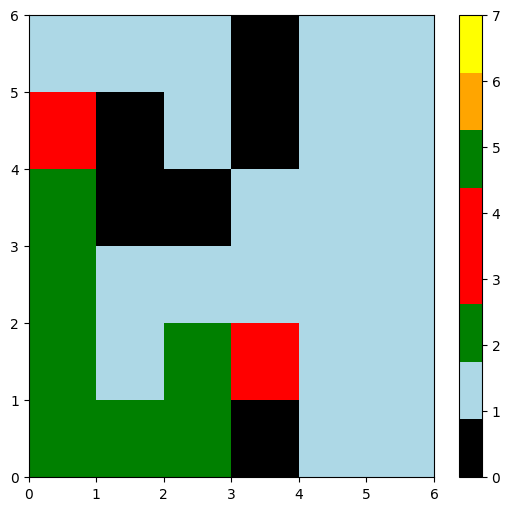

In [45]:
maze = copy.deepcopy(grid1)
destination = Grid_Position(end_node_1[0][0],end_node_1[0][1])
starting_position = Grid_Position(st_node_1[0][0],st_node_1[0][1])
res1, nodes1 = ids_new(maze, destination, starting_position)
print("The Path for the Grid", res1)
print("The Path Cost is:", len(res1))



maze_forward_1 = copy.copy(grid1)

for z, row in enumerate(res1):
    i = row[0]
    j = row[1]
    maze_forward_1[i][j] = 222
    
        
maze_forward_1[st_node_1[0][0]][st_node_1[0][1]]=888
maze_forward_1[end_node_1[0][0]][end_node_1[0][1]]=999
    
my_dict = {0: 0, 1: 1, 111:2,222 :5, 888:3, 999:4}

data1 = []
for i, row in enumerate(maze_forward_1):
    row = [my_dict[zi] for zi in row]
    data1.append(row)
        
from matplotlib.colors import ListedColormap

def plot_examples(colormaps,data):
    np.random.seed(19680801)
    data = data1
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(5,5), constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=7)
        fig.colorbar(psm, ax=ax)
    plt.show()
        
cmap = ListedColormap(["black", "lightblue", "green", "red",'red','green','orange','yellow'])
plot_examples([cmap],data1)

The Path for the Grid [(5, 1), (5, 2), (5, 3), (4, 3), (3, 3), (2, 3), (1, 3), (0, 3)]
The Path Cost is: 8


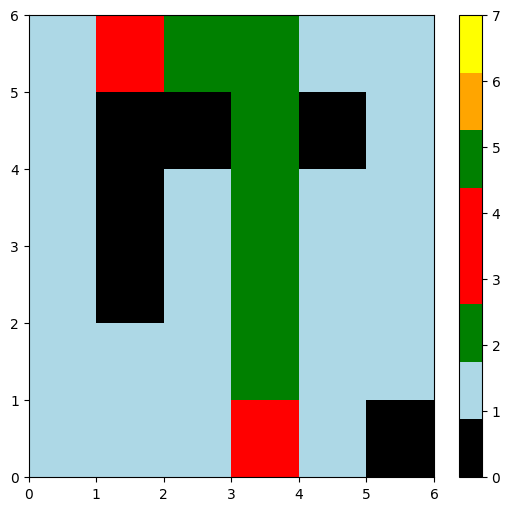

In [46]:
maze = copy.deepcopy(grid2)
destination = Grid_Position(end_node_2[0][0],end_node_2[0][1])
starting_position = Grid_Position(st_node_2[0][0],st_node_2[0][1])
res2, nodes2 = ids_new(maze, destination, starting_position)
print("The Path for the Grid", res2)
print("The Path Cost is:", len(res2))

maze_forward_1 = copy.copy(grid2)

for z, row in enumerate(res2):
    i = row[0]
    j = row[1]
    maze_forward_1[i][j] = 222
    
        
maze_forward_1[st_node_2[0][0]][st_node_2[0][1]]=888
maze_forward_1[end_node_2[0][0]][end_node_2[0][1]]=999
    
my_dict = {0: 0, 1: 1, 111: 2,222 :5, 888:3, 999:4}

data1 = []
for i, row in enumerate(maze_forward_1):
    row = [my_dict[zi] for zi in row]
    data1.append(row)
        
from matplotlib.colors import ListedColormap

def plot_examples(colormaps,data):
    np.random.seed(19680801)
    data = data1
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(5,5), constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=7)
        fig.colorbar(psm, ax=ax)
    plt.show()
        
cmap = ListedColormap(["black", "lightblue", "green", "red",'red','green','orange','yellow'])
plot_examples([cmap],data1)

In [47]:
def ids_new(Grid, dest: Grid_Position, start: Grid_Position):
    depth_limit = 0
    cost = 0
    while True:
        path, a = depth_limited_dfs(Grid, dest, start, depth_limit)

        if path is not None:
            return path,a
        depth_limit += 1

    return -1

def depth_limited_dfs(Grid, dest: Grid_Position, start: Grid_Position, depth_limit):

    adj_cell_x = [1, 0, 0, -1]
    adj_cell_y = [0, 1, -1, 0]
    
    m, n = (len(Grid), len(Grid))
    visited_blocks = [[False for i in range(m)] for j in range(n)]
    
    stack = deque([([(start.x, start.y)], depth_limit)])
    v = {}
    neigh = 4
    cost = 0

    while stack:
        
        path, depth = stack.pop()

        node = path[-1]
        destination = (dest.x, dest.y)
        if node == destination:
            return path, cost
        if depth <= 0:
            continue
        if visited_blocks[node[0]][node[1]] == True:
            continue
        visited_blocks[node[0]][node[1]] = True
        
        v[node] = depth
        
        x_pos, y_pos = node
                
        for i in range(neigh):
            if x_pos == len(Grid) - 1 and adj_cell_x[i] == 0:
                x_pos = node[0]
                y_pos = node[1] + adj_cell_y[i]
            if y_pos == 0 and adj_cell_y[i] == -1:
                x_pos = node[0] + adj_cell_x[i]
                y_pos = node[1]
            else:
                x_pos = node[0] + adj_cell_x[i]
                y_pos = node[1] + adj_cell_y[i]
            
            if x_pos != 10 and x_pos != -1 and y_pos != 10 and y_pos != -1:
                if Grid[x_pos][y_pos] == 1:
                    if visited_blocks[x_pos][y_pos] == False:
                        cost += 1
                        append_path = list(path)
                        append_path.append((x_pos, y_pos))
                        stack.append((append_path, depth - 1))
                
    return None, 0

The Path for the Grid [(2, 6), (2, 5), (2, 4), (2, 3), (1, 3), (0, 3), (0, 2)]
The Path Cost is: 7


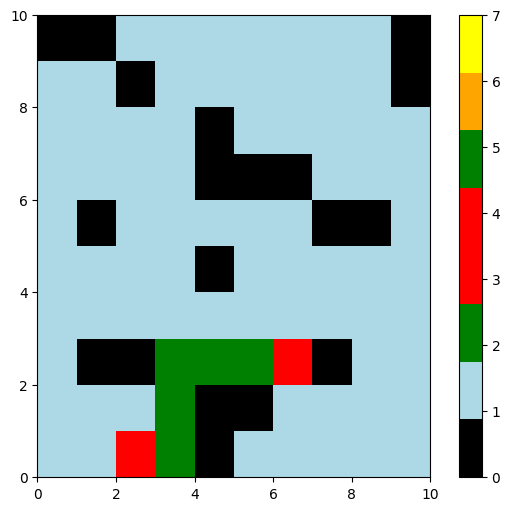

In [48]:
maze = grid
destination = Grid_Position(end_node[0][0],end_node[0][1])
starting_position = Grid_Position(st_node[0][0],st_node[0][1])
    
res, nodes, = ids_new(maze, destination, starting_position)
print("The Path for the Grid", res)
print("The Path Cost is:", len(res))
maze_forward_1 = copy.copy(grid)

for z, row in enumerate(res):
    i = row[0]
    j = row[1]
    maze_forward_1[i][j] = 222
    
        
maze_forward_1[st_node[0][0]][st_node[0][1]]=888
maze_forward_1[end_node[0][0]][end_node[0][1]]=999
    
my_dict = {0: 0, 1: 1, 111: 2,222 :5, 888:3, 999:4}

data1 = []
for i, row in enumerate(maze_forward_1):
    row = [my_dict[zi] for zi in row]
    data1.append(row)
        
from matplotlib.colors import ListedColormap

def plot_examples(colormaps,data):
    np.random.seed(19680801)
    data = data1
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(5,5), constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=0, vmax=7)
        fig.colorbar(psm, ax=ax)
    plt.show()
        
cmap = ListedColormap(["black", "lightblue", "green", "red",'red','green','orange','yellow'])
plot_examples([cmap],data1)